In [1]:
import os
from dypac.masker import LabelsMasker, MapsMasker
from nilearn.plotting import plot_roi, plot_stat_map
from nilearn import datasets

/home/pbellec/.virtualenvs/dypac/local/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


Fetch a cneuromod preprocessed dataset. Here we use a motor run (because it's short). 

In [2]:
# This is on elm
path_cneuromod = '/data/neuromod/DATA/cneuromod/hcptrt/derivatives/fmriprep-20.2lts/fmriprep/sub-01/ses-001/func/'
file_epi = os.path.join(path_cneuromod, 'sub-01_ses-001_task-motor_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

The cneuromod data has low level of motion, so we use a simple denoising strategy, adding a basic global signal regression. This strategy takes up few degrees of freedom, and is quite efficient at reducing motion artifacts. We use the new `load_confounds_strategy` module in nilearn:

In [3]:
from nilearn.interfaces.fmriprep import load_confounds_strategy
conf = load_confounds_strategy(file_epi, denoise_strategy='simple', global_signal='basic')

# Dypac 256 atlas - projection of 4D data

We start by pointing to the dypac models which have been precomputed on the friends-s01 dataset. For each subject, there are parcellations at different resolutions (256, 512, 1024), as well as a mask of the grey matter and a copy of the corresponding T1w individual image for visualization (after non-linear registration in the MNI ICBM asym template).

In [4]:
path_dypac = '/data/cisl/pbellec/models'
file_mask = os.path.join(path_dypac, 'sub-01_space-MNI152NLin2009cAsym_label-GM_mask.nii.gz')
file_dypac = os.path.join(path_dypac, 'sub-01_space-MNI152NLin2009cAsym_desc-dypac256_components.nii.gz')

We first need to build a nilearn `NiftiMasker`. This masker is going to specify how to preprocess the data. Here we just use a simple smoothing, because the rest of the denoising will be taken care of by confound regression.

In [5]:
from nilearn.maskers import NiftiMasker
masker = NiftiMasker(standardize=True, detrend=False, smoothing_fwhm=5, mask_img=file_mask)
masker.fit(file_epi)

NiftiMasker(mask_img='/data/cisl/pbellec/models/sub-01_space-MNI152NLin2009cAsym_label-GM_mask.nii.gz',
            smoothing_fwhm=5, standardize=True)

Now we create a dypac masker. It uses the `NiftiMasker` we just created, as well as the nifti image of the dypac parcels, in order to create a new object. This object has the `transform` and `inverse_transform` methods which are common in nilearn maskers, as well as a few extra helper methods, see below.

In [6]:
maps_masker = MapsMasker(masker=masker, maps_img=file_dypac)

Let's visualize one parcel. They are stored using the `NiftiMasker` defined above, which is available in the attribute `masker_`.

/home/pbellec/.virtualenvs/dypac/local/lib/python3.6/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


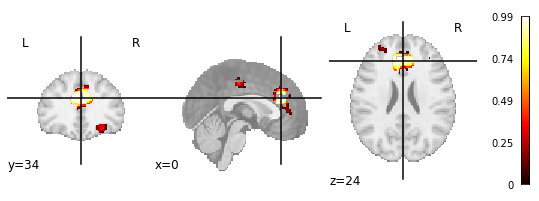

In [7]:
plot_stat_map(maps_masker.masker_.inverse_transform(maps_masker.components_[:, 5].transpose()))

To load the data in parcellation space, we only need to use the `transform` method of the dypac masker. We have 144 time points x 256 parcels, so in parcellation space this dataset is very small. 

In [8]:
tseries = maps_masker.transform(img=file_epi, confound=conf[0])
tseries.shape

(144, 256)

we can also map a vector of values back to voxel space using `inverse_transform`:

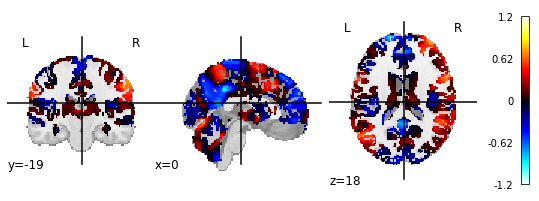

In [9]:
import numpy as np
data_vec = tseries[0, :]
img_avg = maps_masker.inverse_transform(data_vec)
plot_stat_map(img_avg)

One of the helper method can compute a R2 map of quality of time series compression. This means that we compare the original voxel `tseries` to the result of `inverse_transform(transform(img))` using the parcel projection.

In [10]:
r2_map = maps_masker.score(img=file_epi, confound=conf[0])

When visualization this map, we see that there are partial volume effect and a lot of heterogeneity spatially in the quality of compression, but some part of the brain are compressed with very high R2. 

90th percentile R2: 0.5892444546410469


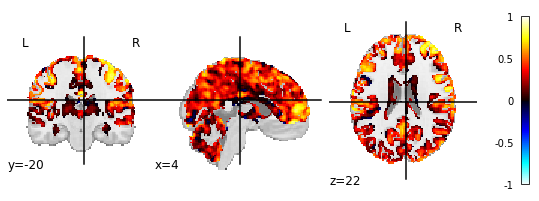

In [11]:
import numpy as np
plot_stat_map(r2_map, vmax=1)
r2_val = NiftiMasker(standardize=False, mask_img=masker.mask_img).fit_transform(r2_map)
print(f'90th percentile R2: {np.percentile(r2_val, 90)}')

# Dypac projection of a single map 

We can use the dypac masker to project single brain maps, for example activation maps. But we need to turn off the temporal standardization for that: 

In [12]:
from nilearn.maskers import NiftiMasker
masker = NiftiMasker(standardize=False, smoothing_fwhm=5, mask_img=file_mask)
masker.fit(file_epi)

NiftiMasker(mask_img='/data/cisl/pbellec/models/sub-01_space-MNI152NLin2009cAsym_label-GM_mask.nii.gz',
            smoothing_fwhm=5)

Let's illustrate how this compression works using a mean EPI image: 

In [13]:
from nilearn.image import mean_img 
epi_mean = mean_img(file_epi)
data_mean = masker.transform(epi_mean)

Here we've simply read the values with our `NiftiMasker`, and we use the `inverse_transform` method to visualize the masked value back on a brain.

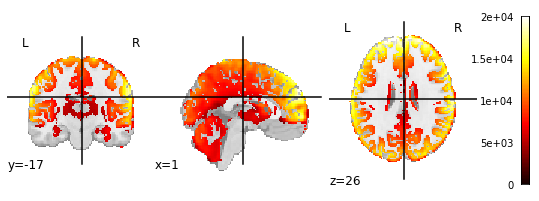

In [14]:
plot_stat_map(masker.inverse_transform(data_mean), vmax=20000, cut_coords=[1, -17, 26])

Now we create a dypac masker, and we use the `compress` method. What this does is project the brain map into the space of the parcels, and then use `inverse_transform` (but this time for parcels), to get back a voxel representation.

In [15]:
maps_masker = MapsMasker(masker=masker, maps_img=file_dypac)
epi_projected = maps_masker.compress(epi_mean)

we visualize the compressed brain map. We can see that the compressed map does capture the main feature of the original, voxel level map. In terms of dimensionality, we went from about 100k voxel values in the grey matter mask to 256 values in parcellation space.

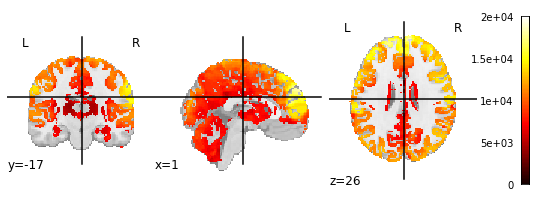

In [16]:
plot_stat_map(epi_projected, vmax=20000, cut_coords=[1, -17, 26])